In [1]:
import os
from math import pi
import numpy as np
import random
import itertools
import scipy.optimize as opt
import matplotlib.pyplot as plt
import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_state_city
# from qiskit_aer.noise import NoiseModel
# from qiskit_ibm_provider import IBMProvider
from qiskit_algorithms.optimizers import SPSA

In [2]:
shots = 100
epsilon_loss = 1e-3 # loss added if test_counts entry is not found
epsilon_parameters=0.1 # scaling factor for initial random parameters (chosen between 0 to 2pi otherwise)

n_qubits = 3
n_bases = 15
depth = 10

max_iter = 1000

param_name = "theta"

# save checkpoints in case the connection to qpu breaks
# useful for running on real qpu, but not necessary for local simulation
have_checkpoints = False
checkpoint_path = "Alt_ideal_ghz_q3_b27_d6_sh100_checkpoints"

# seed = 1000
trial = 0

In [3]:
# random.seed(seed)
rng = np.random.default_rng()

In [4]:
# if have_checkpoints:
#     os.mkdir(checkpoint_path)

In [5]:
# backend = AerSimulator()
# sampler = Sampler.from_backend(backend)
# pm = generate_preset_pass_manager(backend=backend)

simulator_ideal = AerSimulator()
# simulator_ideal.set_options(seed_simulator=seed)
# sampler_ideal = Sampler.from_backend(simulator_ideal)
pm_ideal = generate_preset_pass_manager(backend=simulator_ideal, optimization_level=1)

# sampler = sampler_ideal
pm = pm_ideal

In [6]:
def create_ghz_state(n):
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(n - 1):
        qc.cx(i, i + 1)
    return qc

def get_circ_for_basis(qc: QuantumCircuit, basis: str):
    circ = qc.copy()
    for i, s in enumerate(basis[::-1]): # here, I am using the same endian convention as qiskit, where the last bit represent the first qubit
        if s == 'Z':
            pass
        elif s == 'X':
            circ.ry(-pi/2, i)
        elif s == 'Y':
            circ.rx(pi/2, i)
        else:
            raise ValueError(f"{s} is invalid basis")

    circ.measure_all()

    return circ

def get_isa_circ_list_for_bases(qc: QuantumCircuit, basis_list, pass_manager):
    circ_list = [get_circ_for_basis(qc, basis) for basis in basis_list]
    isa_circ_list = pass_manager.run(circ_list)
    return isa_circ_list


def measure_isa_circ_list_fs(isa_circ_list, basis_list, shots=shots):
    sampler = Sampler(seed =rng.integers(1000000) )
    result_list = sampler.run(isa_circ_list, shots=shots).result()
    counts_list = [result.data.meas.get_counts() for result in result_list]
    results_dic = {basis:counts for (basis, counts) in zip(basis_list, counts_list)}
    return results_dic


def get_basis_list(n_bases,n_qubits):
    bases = ["X", "Y", "Z"]
    basis_list = ["".join(p) for p in itertools.product(bases, repeat=n_qubits)]
    culled_basis_list = random.sample(basis_list, n_bases)
    return culled_basis_list




# def measure_circ_for_all_basis(qc, basis_list, shots=total_shots, sampler=None):
#     results_dic = {}
#     qc_list = [get_circ_for_basis(qc, basis, simulator) for basis in basis_list]
#     job = simulator.run(qc_list, shots=shots)
#     result = job.result()
#     counts_list = result.get_counts()
#     results_dic = {basis:counts for (basis, counts) in zip(basis_list, counts_list)}
    
#     return results_dic

In [7]:
basis_list = get_basis_list(n_bases, n_qubits)
ghz_circ = create_ghz_state(n_qubits)
ghz_circ_isa_list = get_isa_circ_list_for_bases(ghz_circ, basis_list, pm_ideal)
GHZ_measurement = measure_isa_circ_list_fs(ghz_circ_isa_list, basis_list, shots=shots)

In [8]:
print(basis_list)

['ZZY', 'XZX', 'YXZ', 'ZZZ', 'XXY', 'XYY', 'ZZX', 'YXY', 'ZXZ', 'YYZ', 'XYZ', 'YYY', 'YZY', 'YXX', 'XXX']


In [9]:
print(GHZ_measurement)

{'ZZY': {'001': 28, '110': 26, '000': 29, '111': 17}, 'XZX': {'010': 8, '001': 19, '011': 15, '111': 5, '101': 12, '100': 9, '110': 15, '000': 17}, 'YXZ': {'011': 12, '010': 15, '110': 16, '100': 11, '001': 11, '111': 12, '000': 13, '101': 10}, 'ZZZ': {'000': 48, '111': 52}, 'XXY': {'010': 13, '110': 14, '111': 13, '000': 13, '100': 9, '011': 12, '101': 13, '001': 13}, 'XYY': {'100': 32, '010': 19, '111': 32, '001': 17}, 'ZZX': {'000': 26, '111': 24, '110': 28, '001': 22}, 'YXY': {'100': 20, '001': 23, '010': 22, '111': 35}, 'ZXZ': {'010': 30, '111': 25, '101': 23, '000': 22}, 'YYZ': {'111': 11, '100': 14, '000': 14, '101': 18, '110': 10, '001': 16, '011': 6, '010': 11}, 'XYZ': {'001': 12, '000': 13, '110': 18, '010': 16, '111': 11, '011': 11, '101': 11, '100': 8}, 'YYY': {'001': 13, '100': 14, '110': 13, '011': 12, '000': 12, '101': 13, '111': 16, '010': 7}, 'YZY': {'010': 18, '011': 15, '101': 10, '100': 8, '000': 17, '001': 13, '110': 10, '111': 9}, 'YXX': {'101': 14, '111': 18, '11

In [10]:
def initialize_theta_random(circ_depth=10, num_qbits=3):
    """
    Initialize the theta parameter vector
    :param circ_depth: int, number of parameterized layers in circuit
    :param num_qbits: int, number of qbits
    :return: np.array, values of theta
    """

    theta = rng.random(size=(circ_depth, num_qbits))
    theta = 2*pi*epsilon_parameters*theta
    return theta

In [11]:
def construct_variational_circ_ansatz(num_qbits, circ_depth, param_name = param_name):
    """
    Generate a parameterized variational quantum circuit
    
    """

    num_parameters = num_qbits * circ_depth
    theta_vec = ParameterVector(param_name, length=num_parameters)
    var_circ = QuantumCircuit(num_qbits)


    for layer in range(circ_depth - 1):
        # Compute if layer is odd or even to apply rx or ry gate to circuit
        is_odd_step = (layer + 1) % 2

        for qbit in range(num_qbits):
            if is_odd_step:
                var_circ.rx(theta_vec[layer * num_qbits + qbit], qbit)
            else:
                var_circ.ry(theta_vec[layer * num_qbits + qbit], qbit)

        # Apply CX gates
        for qbit in range((1-is_odd_step), num_qbits-1, 2):
            # isOddStep may subtract 1 if True, to correctly apply cx gate location
            var_circ.cx(qbit , qbit + 1)
            var_circ.barrier() # for visualization only

    for qbit in range(num_qbits):  # bonus layer at the end only has rx gates and no cx
        var_circ.rx(theta_vec[(circ_depth - 1) * num_qbits + qbit], qbit)

    return var_circ, theta_vec


In [12]:
ansatz, param_vec = construct_variational_circ_ansatz(n_qubits, depth, param_name=param_name)

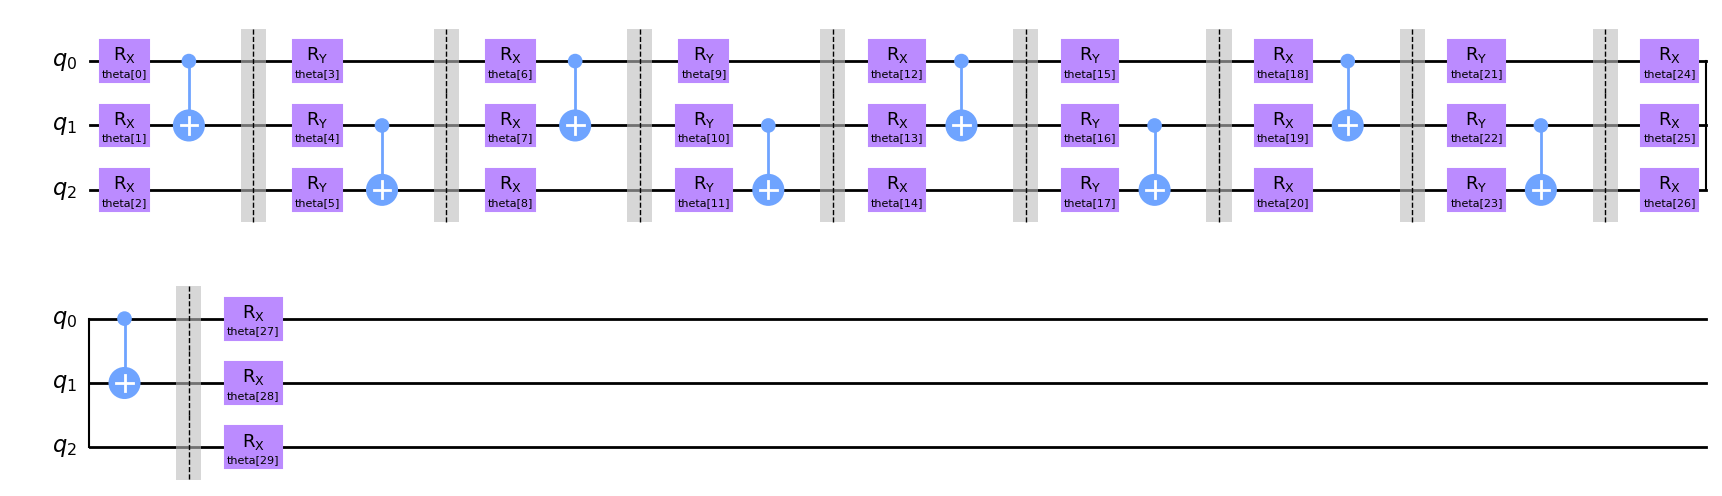

In [13]:
ansatz.draw(output="mpl", style="clifford")

In [14]:
ansatz_isa_list = get_isa_circ_list_for_bases(ansatz, basis_list, pm)

In [15]:
def get_ansatz_output(ansatz_isa_list, parameters, basis_list, shots, param_placeholder=param_vec):
    circ_run_list = [circ.assign_parameters({param_placeholder:parameters}) for circ in ansatz_isa_list]
    return measure_isa_circ_list_fs(isa_circ_list=circ_run_list, basis_list=basis_list, shots=shots)

In [16]:
def KL_divergence(true_data, test_data, epsilon_loss = epsilon_loss):
    loss = 0

    # here, let me assume true data and test data can have different number of shots
    # but the shot in each basis should be the same
    true_data_total_shots = sum(list(true_data.values())[0].values())
    test_data_total_shots = sum(list(test_data.values())[0].values())

    for basis in true_data: # just a note that if there are hallucinated measurements in 
        # bases/states not included in the true data then the kl divergence will not account for these (at least as presented in the paper)
        for state in true_data[basis]:
            true_counts = true_data[basis][state]
            test_counts = test_data[basis].get(state, 0)
            true_prob   = true_counts / true_data_total_shots
            test_prob   = test_counts / test_data_total_shots
            loss += true_prob *(np.log((true_prob)/(test_prob +epsilon_loss)))

    return loss / len(true_data)

In [17]:
global loss_values
global thetas

loss_values = []
thetas = []

In [18]:
def compute_kl_loss(theta_vector, ansatz_isa_list,  basis_list, true_data, shots, param_placeholder=param_vec, \
        print_message=True, have_checkpoints=have_checkpoints, checkpoint_path=checkpoint_path):
    # theta = np.reshape(theta_vector, (circ_depth, num_qbits))
    # tempcirc = construct_variational_circ(theta=theta)
    test_data = get_ansatz_output(ansatz_isa_list=ansatz_isa_list, parameters=theta_vector, basis_list=basis_list, \
        shots=shots, param_placeholder=param_placeholder)
    # test_data = measure_circ_for_all_basis(qc = tempcirc, basis_list=basis_list, simulator=simulator)
    loss = KL_divergence(true_data, test_data) + \
        KL_divergence(test_data, true_data) # symmetrizing the loss

    global loss_values
    global thetas 
    loss_values.append(loss)
    thetas.append(theta_vector)

    num_iter = len(loss_values)

    if print_message:
        print(f"Iteration {num_iter:5}; current loss is {loss}")

    if have_checkpoints:
        # save checkpoints in case the connection to qpu breaks
        # useful for running on real qpu, but not necessary for local simulation
        np.save(os.path.join(checkpoint_path, f"theta_iter{num_iter}.npy"), thetas)
    
    return loss


In [19]:
# wraps the function with the all arguments but theta vector already filled

def compute_kl_loss_filled(theta_vector):
    return compute_kl_loss(theta_vector, ansatz_isa_list, basis_list, GHZ_measurement, shots, param_vec, print_message=True)

def compute_kl_loss_filled_quiet(theta_vector):
    return compute_kl_loss(theta_vector, ansatz_isa_list, basis_list, GHZ_measurement, shots, param_vec, print_message=False)


In [20]:
%%time

theta = initialize_theta_random(circ_depth=depth, num_qbits = n_qubits)
theta_vector = np.reshape(theta, theta.size)
circ_depth, num_qbits = theta.shape

spsa = SPSA(maxiter=300)
# c=0.1258
# A=0.3186
# a1=0.4739
# alpha=0.6374
# gamma=0.06059
# (lr, p) = spsa.calibrate(compute_kl_loss_filled, theta_vector, c=c, stability_constant = A, target_magnitude=a1, alpha=alpha, gamma=gamma)
# spsa.learning_rate = lr
# spsa.perturbation = p

# args = (ansatz_isa_list, basis_list, GHZ_measurement, shots, param_vec)

# results = opt.minimize(compute_kl_loss, theta_vector, args = args, method = "Powell", options={"maxiter":max_iter})

results = spsa.minimize(compute_kl_loss_filled, theta_vector)

Iteration     1; current loss is 2.9102801210518408
Iteration     2; current loss is 3.0652987811227357
Iteration     3; current loss is 3.2104785142899406
Iteration     4; current loss is 2.7518984091856566
Iteration     5; current loss is 2.974512632589708
Iteration     6; current loss is 2.516813261060678
Iteration     7; current loss is 2.9908148430620827
Iteration     8; current loss is 2.7105595145587125
Iteration     9; current loss is 2.849373986291565
Iteration    10; current loss is 2.8016158081563836
Iteration    11; current loss is 2.800125560985959
Iteration    12; current loss is 2.536680277009432
Iteration    13; current loss is 3.0166234931501457
Iteration    14; current loss is 2.8156546601686276
Iteration    15; current loss is 2.4136622605772615
Iteration    16; current loss is 2.596676765684112
Iteration    17; current loss is 2.8306816660357406
Iteration    18; current loss is 2.4346278250250597
Iteration    19; current loss is 3.1100977916141526
Iteration    20; c

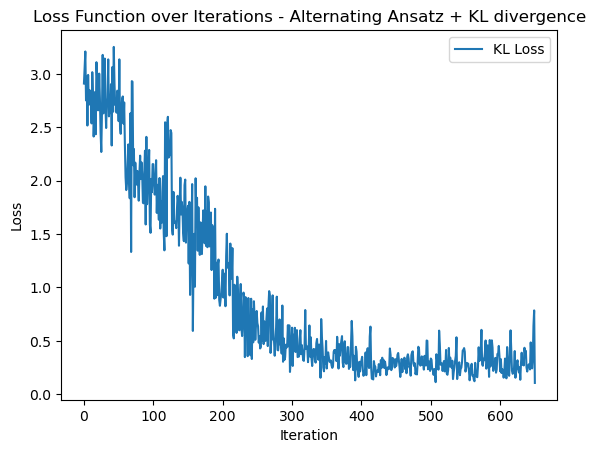

In [21]:
fig, ax = plt.subplots()
ax.plot(loss_values, label=f"KL Loss")
# plt.ylim(0, 30)
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title(f"Loss Function over Iterations - Alternating Ansatz + KL divergence")
ax.legend()

# fig.savefig("loss_curve.png")

In [22]:

def simulate_circ(circ):
    """
    Generates our estimate state |phi> via simulation
    :param circ: qiskit.QuantumCircuit object, the variational quantum circuit
    :return: qiskit.Statevector object, represents our estimated quantum state |phi>
    """

    simulator = AerSimulator(method='statevector')
    circ.save_statevector() 
    job = simulator.run(circ)
    result = job.result()
    circ_statevect = Statevector(result.get_statevector(circ))
    
    return circ_statevect

def compute_fidelity(psi, phi):
    """
    Compute the fidelity (a measure of similarity) between the two states
    :param psi: qiskit.Statevector, our target state |psi>
    :param phi: qiskit.Statevector, our estimated state |phi>
    :return: float, fidelity
    """

    fidelity = qiskit.quantum_info.state_fidelity(psi, phi)
    print(f"psi: {psi}, phi: {phi}")
    # fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # plot_bloch_multivector(psi)
    # axes[0].set_title("psi")
    # plot_bloch_multivector(phi)
    # axes[1].set_title("phi")
    return fidelity



ghz_state = Statevector.from_instruction(ghz_circ)
ansatz_state = Statevector.from_instruction(ansatz.assign_parameters({param_vec : results.x}))

final_fidelity = qiskit.quantum_info.state_fidelity(ghz_state, ansatz_state)

In [23]:
print(f"ghz state: {ghz_state}\nansatz: {ansatz_state}")

ghz state: Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.70710678+0.j],
            dims=(2, 2, 2))
ansatz: Statevector([-0.31716247+0.65240967j,  0.0153138 -0.00839922j,
             -0.01988269-0.04820247j,  0.0245004 -0.00087746j,
             -0.0161913 +0.02149074j,  0.01463626+0.02021281j,
              0.02185301+0.05239697j, -0.22603192+0.64380469j],
            dims=(2, 2, 2))


In [24]:
print(final_fidelity)

0.9876159048939134


In [25]:
print(results.x)

[ 1.96144039  0.72676817  0.01467313  4.08426616  2.18439344 -1.56224554
 -1.78191138 -3.15332803  0.39244174  1.02873989  5.35848621 -4.70593488
 -2.81221616  2.42862798 -0.61030087  0.0445544  -1.47079438  3.24603803
  4.82813787 -3.29969042  2.78496717 -1.77396887 -0.31541314  3.79553977
 -1.15949053 -0.58270074 -0.11735331  6.48540258 -2.19280273 -0.93908783]


In [26]:
np.save(f"saved/params_training_s{trial}.npy", thetas)
np.save(f"saved/loss_training_s{trial}.npy", loss_values)
np.save(f"saved/final_theta_s{trial}.npy", results.x)
np.save(f"saved/fidelity_s{trial}.npy", final_fidelity)

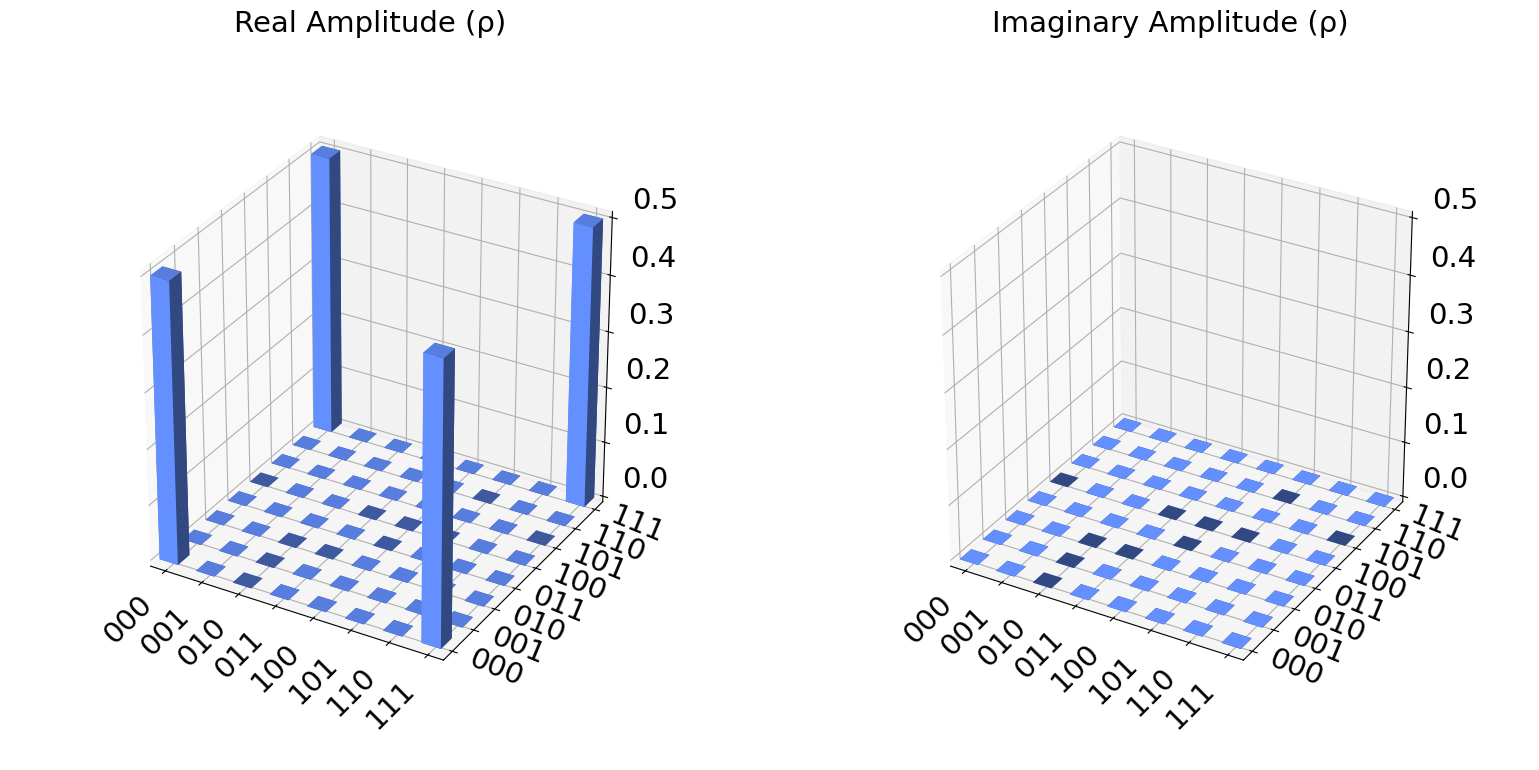

In [27]:
plot_state_city(ghz_state)

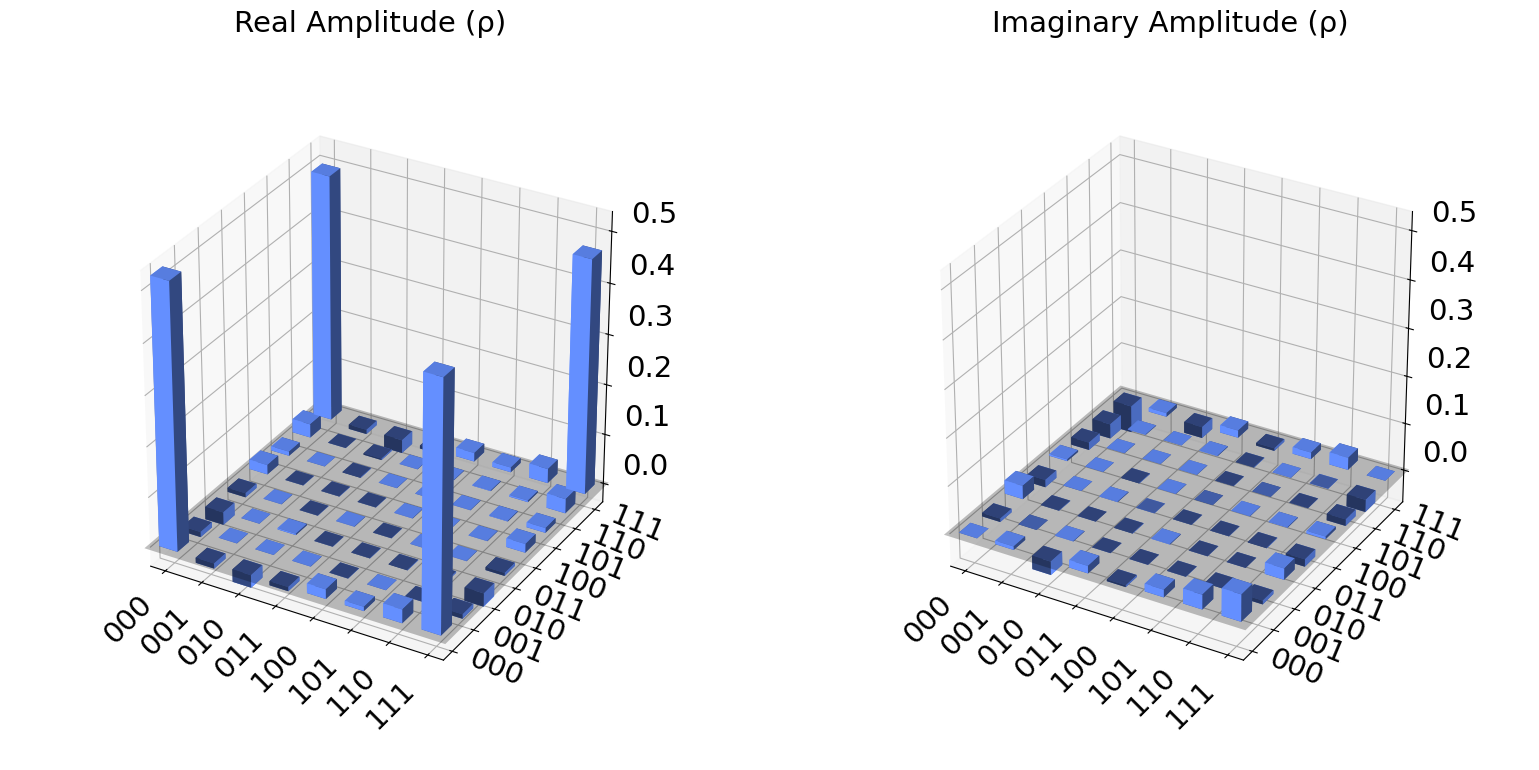

In [28]:
plot_state_city(ansatz_state)